## Charity寻找捐献者

项目使用1994年美国人口普查收集的数据，包括14个变量，目的是利用这14个变量预测被调查者年收入是否超过5万美元。
了解人群收入情况可以使该盈利组织获得更好的收入，因为一般收入人群对该组织的捐赠能力有限，定位到高收入人群才有可能在后续捐赠过程中获得更多收入。

对原有的数据集进行了一些改变，移除了特征`'fnlwgt'` ,同时处理缺失值并对数据格式进行了规整

### 变量解释

收入(目标变量) income: >50K, <=50K.     
年龄 age: continuous.     
工作类别 workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.     
教育 education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.     
受教育年限 education-num: continuous.     
婚姻状况 marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.     
职业/行业 occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.     
家庭关系 relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.     
种族 race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.     
性别 sex: Female, Male.     
资本收益 capital-gain: continuous.     
资本损失 capital-loss: continuous.     
每周工作时长 hours-per-week: continuous.     
原籍 native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.    

### 导入数据

In [1]:
import numpy as np
import pandas as pd
import math as ma
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from IPython.display import display
import visualization as vs # 导入自定义可视化脚本
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

In [2]:
data = pd.read_csv("census.csv")
# data.info()
data.head(3)
# 后面需要对目标变量income需要进行重新编码

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K


In [3]:
less_50k = data[data.income == '<=50K'].shape[0]
over_50k = data[data.income == '>50K'].shape[0]
percent = (over_50k/data.shape[0])*100

print ("年收入超过5万美元的人占{:.2f}%".format(percent))

年收入超过5万美元的人占24.78%


### 预处理
项目会用到逻辑回归所以会对数据进行较多的预处理

In [4]:
# 将数据切分成特征和对应的标签
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

In [5]:
features_raw.describe()
# 可以看到capital-gain,capital-loss两个变量的值分布均衡

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


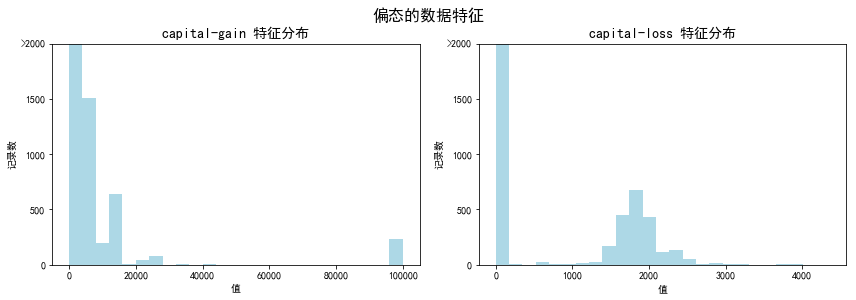

In [6]:
# capital-gain 和 capital-loss两个变量严重有偏
vs.distribution(features_raw[['capital-gain', 'capital-loss']])

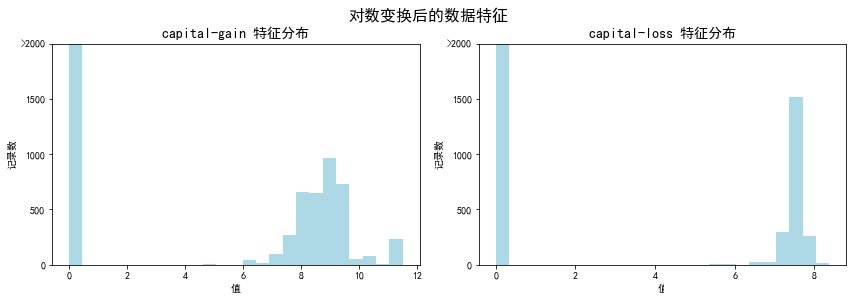

In [7]:
# 对于高度倾斜分布的两个特征，将数据转换成对数，这样可以减小对算法的影响，
# 使用对数变换显著降低了由于异常值所造成的数据范围异常
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log1p(x))

# 对数转换后 'capital-gain'和'capital-loss' 两个特征
vs.distribution(features_raw[skewed], transformed = True)

### 数值型变量规一化

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

d:\softwares\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### 分类变量一位有效编码

In [9]:
features = pd.get_dummies(features_raw)

# 年收入超过5万美金的设为1，另一类设置为0
income = income_raw.map({'<=50K':0,'>50K':1})

encoded = list(features.columns)
print ("{} 个编码后变量.".format(len(encoded)))

# 移除下面一行的注释以观察编码的特征名字
# print (encoded)

103 个编码后变量.


### 切分数据

In [10]:
from sklearn.model_selection import train_test_split

# 切分成训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state=305,
                                                    stratify = income)
# 进一步将训练集切分为训练集和验证集用于训练模型
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=305,
                                                    stratify = y_train)

# 显示切分的结果
print ("训练集 {}.".format(X_train.shape[0]))
print ("验证集 {}.".format(X_val.shape[0]))
print ("测试集 {}.".format(X_test.shape[0]))

训练集 28941.
验证集 7236.
测试集 9045.


## 建模型性能测试
在这一部分中，我们将尝试三种不同的算法，并确定哪一个能够最好地建模数据

### 评价指标

In [11]:
# 只对收入超过5万美元以上的有兴趣，使用准确率作为评价模型的标准之一
# 其次，错把收入大于5万美金的人当成高收入者会增加后面的投入成本
# 最终调整到模型准确率高于查全率，使用F-0.5作为评价指标，这样能够同时考虑查准率和查全率
y_pred =  np.linspace(1,1,num=len(y_val))
TP = sum(y_val == y_pred)
FP = sum(y_val != y_pred)
FN = 0

accuracy = sum(y_pred == y_val)/len(y_val)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
fscore = (1+0.5**2)*(precision*recall)/((0.5**2*precision)+recall)

### 定义测试函数

In [12]:
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_val, y_val): 
    
    results = {}
    
    # sample_size大小的训练数据来拟合学习器
    sampled_row = pd.Series(X_train.index).sample(n = sample_size)
    temp_x = X_train.loc[sampled_row,:]
    temp_y = y_train.loc[sampled_row]
    start = time() # 程序开始时间
    learner = learner.fit(temp_x,temp_y)
    end = time() # 程序结束时间
    
    #计算训练时长
    results['train_time'] = end - start
    start = time()
    predictions_val = learner.predict(X_val)
    predictions_train = learner.predict(temp_x)
    end = time()
    results['pred_time'] = end - start
            
    # 训练集-准确率
    results['acc_train'] = accuracy_score(temp_y,predictions_train)   
    # 验证集-准确率
    results['acc_val'] = accuracy_score(y_val,predictions_val)
    # 训练集-F得分
    results['f_train'] = fbeta_score(temp_y,predictions_train,beta=0.5)   
    # 验证集-F得分
    results['f_val'] = fbeta_score(y_val,predictions_val,beta=0.5)
       
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # 返回结果
    return results

### 模型的评估
在下面的代码单元中，您将需要实现以下功能：             
- 导入你在前面讨论的三个监督学习模型。             
- 初始化三个模型并存储在`'clf_A'`，`'clf_B'`和`'clf_C'`中。
  - 使用模型的默认参数值，在接下来的部分中你将需要对某一个模型的参数进行调整。             
  - 设置`random_state`  (如果有这个参数)。       
- 计算1%， 10%， 100%的训练数据分别对应多少个数据点，并将这些值存储在`'samples_1'`, `'samples_10'`, `'samples_100'`中

**注意：**取决于你选择的算法，下面实现的代码可能需要一些时间来运行！

DecisionTreeClassifier trained on 2894 samples.
DecisionTreeClassifier trained on 8682 samples.
DecisionTreeClassifier trained on 28941 samples.
LogisticRegression trained on 2894 samples.
LogisticRegression trained on 8682 samples.
LogisticRegression trained on 28941 samples.
GradientBoostingClassifier trained on 2894 samples.
GradientBoostingClassifier trained on 8682 samples.
GradientBoostingClassifier trained on 28941 samples.


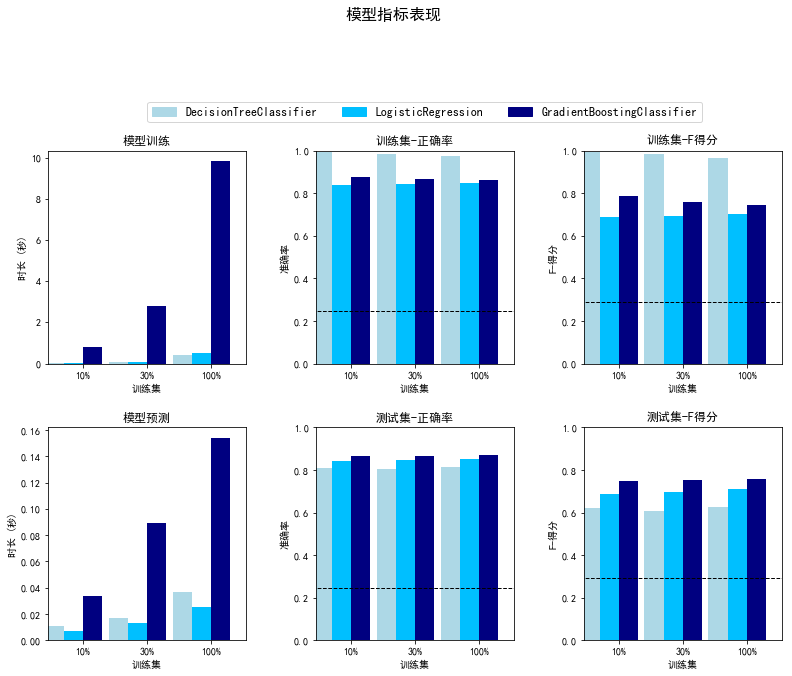

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

dt = DecisionTreeClassifier(random_state=305)
lr = LogisticRegression(solver='liblinear', random_state=305)
gbm = GradientBoostingClassifier(random_state=305)

# 10%， 30%， 100%的训练数据分别对应多少点m
sp_10 = int(y_train.shape[0]*0.1)
sp_30 = int(y_train.shape[0]*0.3)
sp_100 = y_train.shape[0]

y_pred =  np.linspace(1,1,num=len(y_val))

# 收集学习器的结果
results = {}
for clf in [dt, lr, gbm]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([sp_10, sp_30, sp_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_val, y_val)

vs.evaluate(results, accuracy, fscore)

# 通过下图可以明显看出，三个算法的特点
# 决策树和逻辑回归算法速度快，但模型的精度不如提升算法，同时决策树算法的过拟合较为明显
# 虽然提升树算法较慢但在数据集不是很大的情况如果追求更高的精度那么可以选择提升算法

### 参数调优
最终选择提升算法作为最终模型，使用网格搜索对模型参数进行调优

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import make_scorer
clf = GradientBoostingClassifier(random_state=305)

# 调节参数列表
parameters = {'learning_rate':[0.1,0.2],
              'n_estimators':range(40,101,20)}

# 评分标准为f-0.5
scorer = make_scorer(fbeta_score,beta=0.5)
# 5次随机切分
cv_sets = ShuffleSplit(n_splits=5, test_size=0.20, random_state=305)

# 使用网格搜索最优化f-0.5
grid_obj_gbm = GridSearchCV(clf, parameters, scoring=scorer, cv=cv_sets, n_jobs=-1)
grid_obj_gbm.fit(X_train,y_train)
best_clf_gbm = grid_obj_gbm.best_estimator_
predictions = (clf.fit(X_train, y_train)).predict(X_val)
best_predictions = best_clf_gbm.predict(X_val)

# 汇报调优后的模型
print ("最优模型参数:")
print (best_clf_gbm)

# 汇报调参前和调参后的分数
print ("\n未调参模型:")
print ("验证集-正确率: {:.4f}".format(accuracy_score(y_val, predictions)))
print ("验证集-F得分: {:.4f}".format(fbeta_score(y_val, predictions, beta = 0.5)))
print ("\n调参后模型:")
print ("调参后 验证集-正确率: {:.4f}".format(accuracy_score(y_val, best_predictions)))
print ("调参后 验证集-F得分: {:.4f}".format(fbeta_score(y_val, best_predictions, beta = 0.5)))

最优模型参数:
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=305,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

未调参模型:
验证集-正确率: 0.8684
验证集-F得分: 0.7588

调参后模型:
调参后 验证集-正确率: 0.8748
调参后 验证集-F得分: 0.7689


### 练习 - 提取特征重要性

选择一个`scikit-learn`中有`feature_importance_`属性的监督学习分类器，这个属性是一个在做预测的时候根据所选择的算法来对特征重要性进行排序的功能。

在下面的代码单元中，你将要实现以下功能：
 - 如果这个模型和你前面使用的三个模型不一样的话从sklearn中导入一个监督学习模型。
 - 在整个训练集上训练一个监督学习模型。
 - 使用模型中的 `'feature_importances_'`提取特征的重要性。

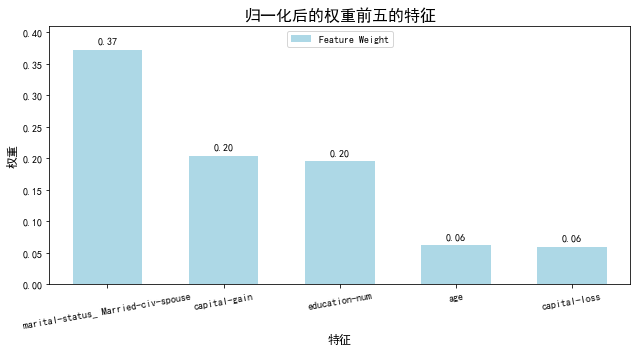

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(random_state=305,learning_rate=0.2,n_estimators=80)
model.fit(X_train,y_train)

# 因为特征较多所以只列出排在前五的重要性
importances = model.feature_importances_

vs.feature_plot(importances, X_train, y_train)
# 最终得到已婚，资本收益，受教育时间，年龄和资本损失为影响收入的5个最主要因素

### 结论



In [16]:
# 最终模型测试集上的准确率与F-0.5得分
y_test_pred = best_clf_gbm.predict(X_test)
print (accuracy_score(y_test, y_test_pred))
print (fbeta_score(y_test, y_test_pred, average = 'binary', beta=0.5))

# 由于提升算法模型训练时间较长特别是在调参时需要多次拟合，如果数据集较大会耗时更久
# 如果对模型精度要求不是很高的情况下可以用逻辑回归算法

0.8664455500276396
0.7519845526711006
